In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import fenics as fe
import fenics_adjoint as fa
import torch
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv004
--------------------------------------------------------------------------


In [3]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase =  0

In [4]:
ds = project.imaging.Emory4DCTDataset('../data/Emory-4DCT', case_names=[case_name], phases=[ei_phase, ee_phase])
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [5]:
case = ds[0]

ee_anat_image = case.array.sel(phase=50)
ei_anat_image = case.array.sel(phase=0)

ee_lung_mask = case.mask.sel(phase=50, roi='lung_combined_mask')
ei_lung_mask = case.mask.sel(phase=0, roi='lung_combined_mask')

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

<IPython.core.display.Javascript object>


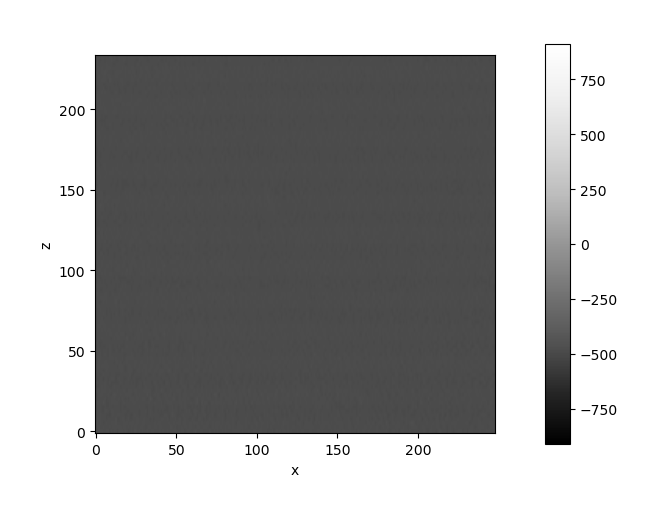

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [6]:
project.visual.view(ee_anat_image * ee_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


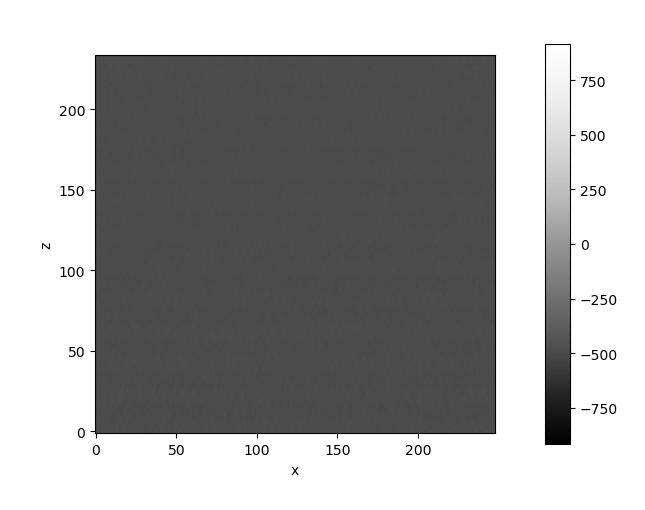

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [10]:
project.visual.view(ei_anat_image * ei_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


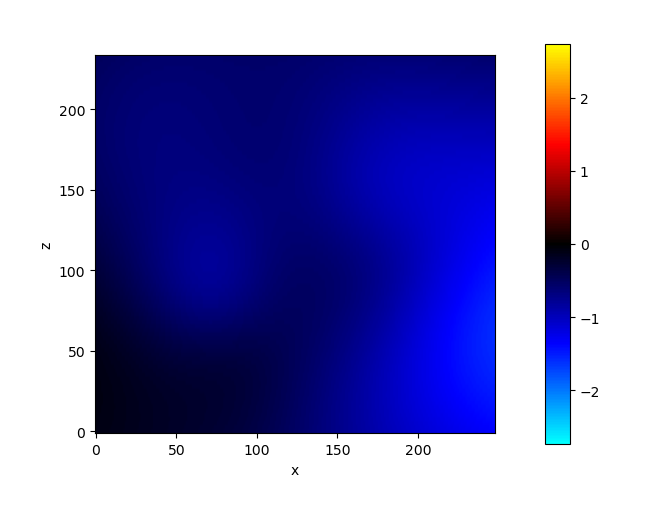

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [11]:
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


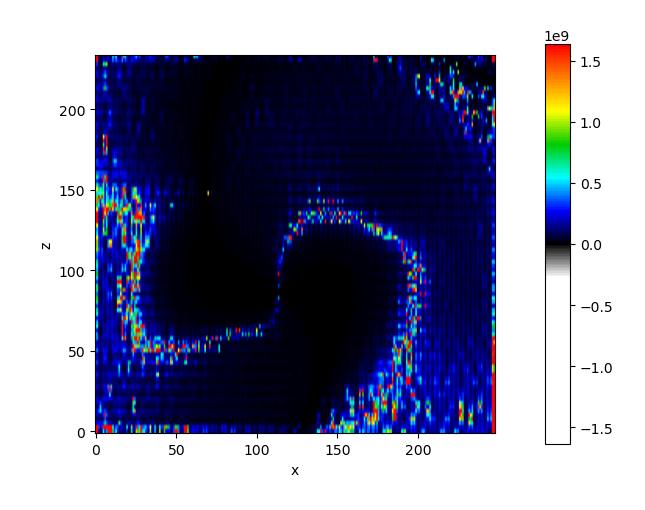

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [12]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(np.abs(elast_image) * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map())

In [14]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=5.0,
    odt=True
)

CPU times: user 5.07 s, sys: 31.2 ms, total: 5.1 s
Wall time: 5.11 s


In [16]:
%%time
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

#angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
#tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

CPU times: user 2.72 ms, sys: 1.69 ms, total: 4.41 ms
Wall time: 3.15 ms


((14068, 3), (19468, 3), (69594, 4))

<IPython.core.display.Javascript object>


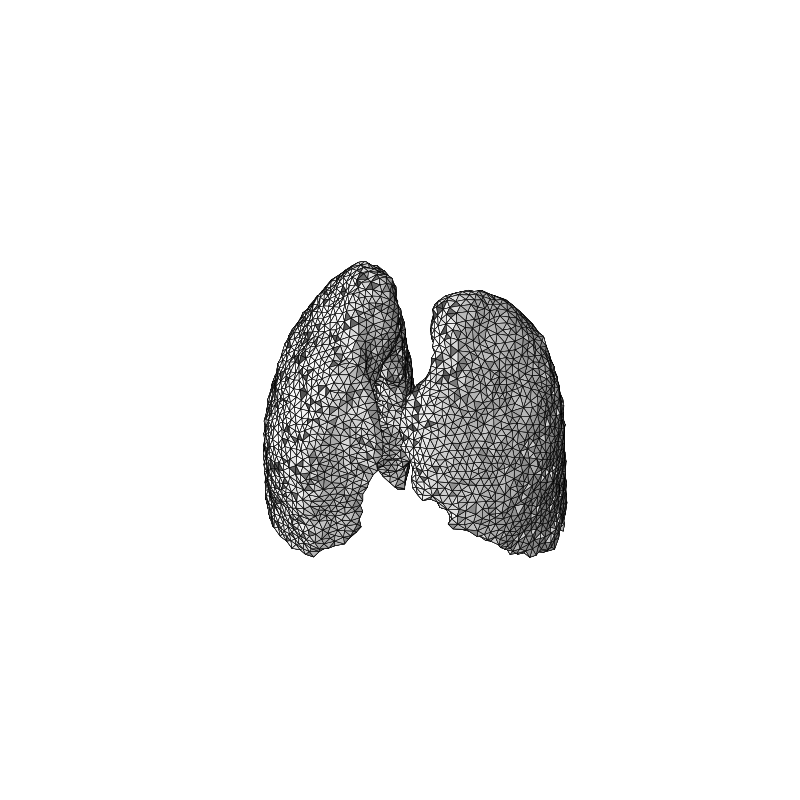

In [17]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets, #[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


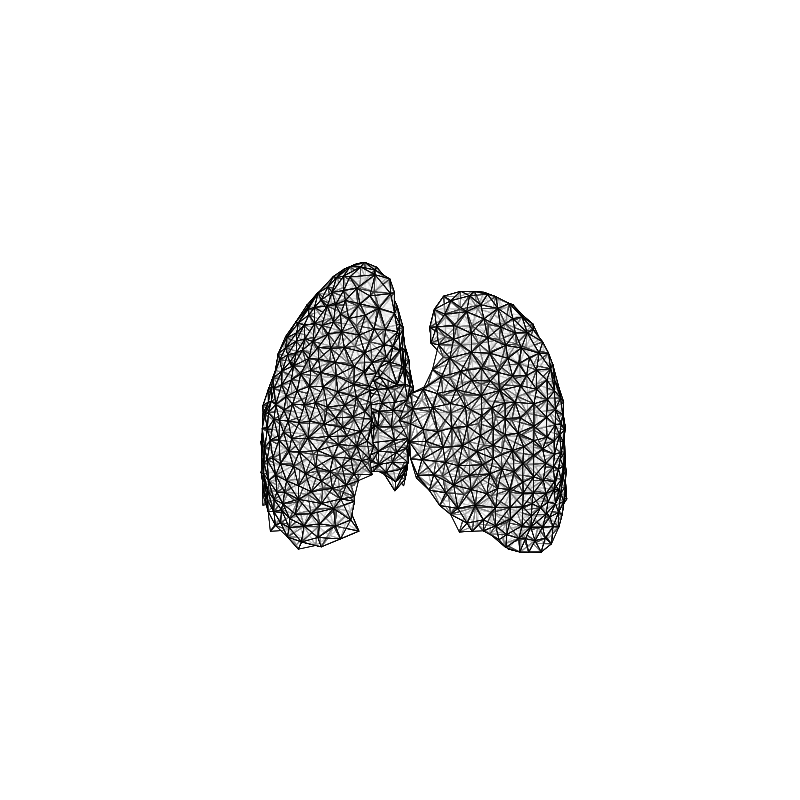

In [14]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [18]:
import meshio
import fenics as fe
from mpi4py import MPI

In [19]:
def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])

In [20]:
%%time
import torch
import torch.nn.functional as F

# functions for converting between image-like arrays 
#   and vectors of coefficients for a linear FEM basis

def image_to_dofs(image, resolution, V):
    '''
    Args:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
    Returns:
        dofs: (batch_size, mesh_size, n_channels) torch.Tensor
    '''
    n_x, n_y, n_z, n_c = image.shape
    
    dof_coords = V.tabulate_dof_coordinates()
    dof_coords = dof_coords[::V.num_sub_spaces(),:]
    
    mesh_size, n_dims = dof_coords.shape

    dof_coords = torch.as_tensor(dof_coords, dtype=image.dtype, device=image.device)

    shape = torch.as_tensor([n_x, n_y, n_z], dtype=image.dtype, device=image.device)
    resolution = torch.as_tensor(resolution, dtype=image.dtype, device=image.device)
    extent = (shape - 1) * resolution

    dofs = F.grid_sample(
        input=image[None,...].permute(0,4,3,2,1), # xyzc -> bczyx
        grid=(dof_coords[None,None,None,...] / extent) * 2 - 1,
        align_corners=True
    )
    return dofs.view(n_c, mesh_size).permute(1,0)


u_tensor = torch.as_tensor(reg_disp_image.values)
u_func_space = fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)
u_func_dofs = image_to_dofs(u_tensor, case.resolution, u_func_space)

CPU times: user 162 ms, sys: 7.05 ms, total: 169 ms
Wall time: 209 ms


In [21]:
%%time
import torch_fenics

def dofs_to_image(dofs, V, image_shape, resolution):
    '''
    Args:
        dofs: (mesh_size, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
        image_shape: (int, int, int) tuple
    Returns:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
    '''
    mesh_size, n_c = dofs.shape
    n_x, n_y, n_z = image_shape

    x = np.arange(n_x) * resolution[0]
    y = np.arange(n_y) * resolution[1]
    z = np.arange(n_z) * resolution[2]

    grid = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)
    print(image_shape, grid.shape)

    func = torch_fenics.numpy_fenics.numpy_to_fenics(
        dofs.detach().cpu().numpy(), fe.Function(V)
    )
    func.set_allow_extrapolation(True)

    image = np.zeros((n_x, n_y, n_z, n_c))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                func.eval(image[i,j,k], grid[i,j,k])

    return image

u_interp = dofs_to_image(u_func_dofs, u_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 3min 10s, sys: 185 ms, total: 3min 10s
Wall time: 3min 11s


<IPython.core.display.Javascript object>


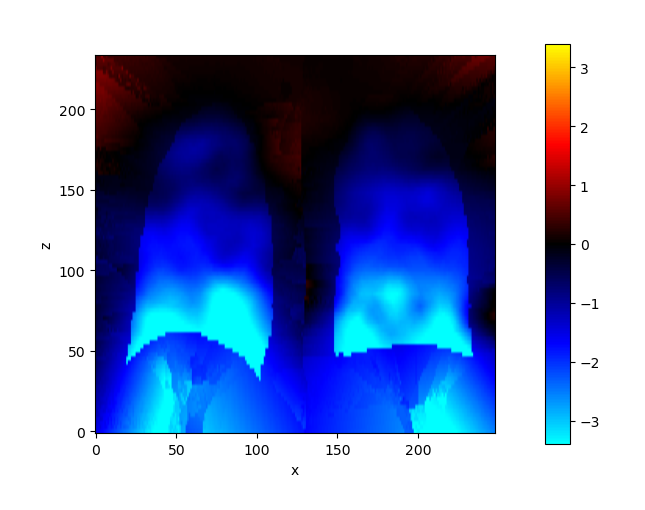

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [24]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_interp) * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


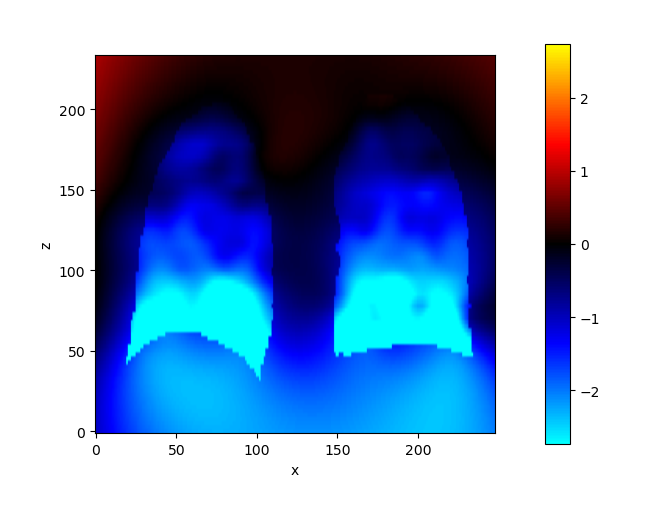

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [25]:
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z')

$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$

In [34]:
%%time

class XArrayExpression(fe.UserExpression):
    def __init__(self, array):
        super().__init__()
        self.interp = scipy.interpolate.RegularGridInterpolator(
            points=(array.x, array.y, array.z),
            values=array.values,
            method='cubic'
        )
    def eval(self, values, x):
        values[...] = self.interp(x)
    def value_shape(self):
        return (3,)


class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.u_func_space = fe.VectorFunctionSpace(mesh, 'P', 1)
        self.mu_func_space = fe.FunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.u_func_space),
            #fa.Function(self.mu_func_space)
        )

    def solve(self, u_true):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        rho = 1.0 # mass density (kg/m^3)

        E  = 3e3 # Young's modulus (Pa = N/m^2)
        nu = 0.4 # Poisson's ratio (unitless)

        lam = E*nu/((1 + nu)*(1 - 2*nu)) # Lame's first parameter (Pa)
        mu  = E   /(2*(1 + nu))          # shear modulus (Pa) 

        # set displacement boundary condition
        def fixed_boundary(x, on_boundary):
            return on_boundary

        u_bc = fe.DirichletBC(self.u_func_space, u_true, fixed_boundary)

        # body force and traction
        b = fe.Constant((0, 0, -rho * g))
        t = fe.Constant((0, 0, 0))

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # setup variational problem
        u = fe.TrialFunction(self.u_func_space)
        v = fe.TestFunction(self.u_func_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fe.Function(self.u_func_space)
        fe.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
u_func_dofs = image_to_dofs(u_tensor, case.resolution, pde_solver.u_func_space)
u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0))[0]

CPU times: user 8.12 s, sys: 349 ms, total: 8.47 s
Wall time: 2.63 s


In [35]:
%%time
u_pred_image = dofs_to_image(u_pred_func_dofs, pde_solver.u_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 3min 10s, sys: 189 ms, total: 3min 10s
Wall time: 3min 11s


<IPython.core.display.Javascript object>


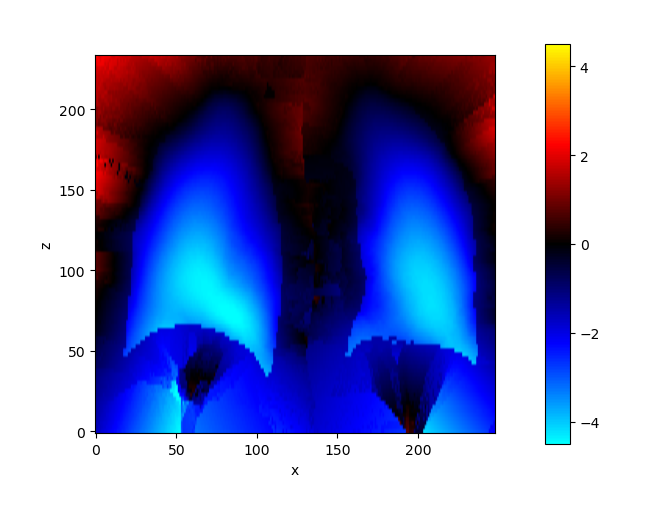

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [43]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


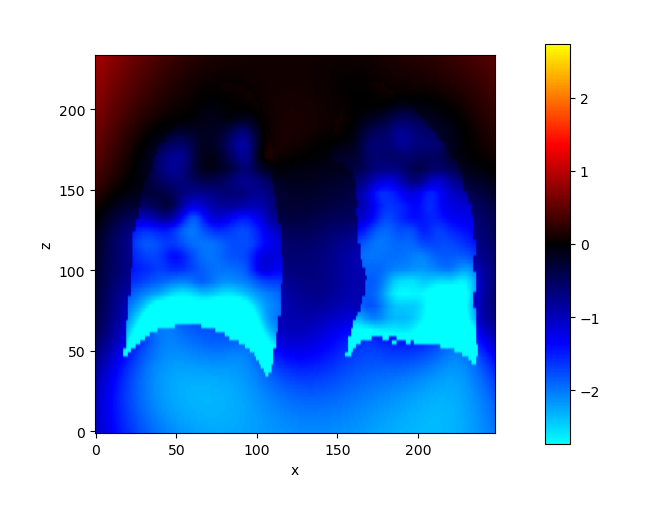

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [44]:
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z')

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')